# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision using the cat vs dog of yesterday.

Transfer Learning consists of using, for the feature extraction part, the weights of a model that has been already trained on another dataset. 

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from torch.utils.data import DataLoader

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

>**Bonus Exercise**: Try this at the end: build a data augmentation pipeline using Albumentations library (check the other notebook).

In [11]:
## Load and preprocess the Cat vs Dog dataset of yesterday. 
## The images should have size 224x224

data_dir = './Cat_Dog_data'

# TODO: Define transforms for the training data and testing data

train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                    ])



# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir,"test"), transform=test_transforms)

trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on. You can pick other models as well from here: https://pytorch.org/docs/0.3.0/torchvision/models.html#id5

<AxesSubplot:>

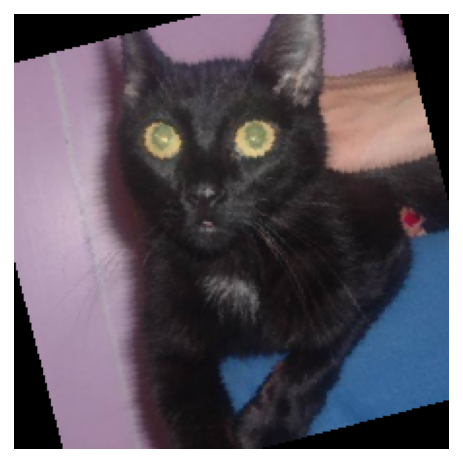

In [12]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# Run this to test your data loaders
# images, labels = next(iter(trainloader))
# imshow(images[0], normalize=True)

images, labels = next(iter(trainloader))
imshow(images[0])

In [13]:
model = models.densenet121(pretrained=True)
model

enseLayer(
        (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(288, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer3): _DenseLayer(
        (norm1)

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means **we need to replace the classifier, but the features will work perfectly on their own**. *In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.*



In [14]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
our_classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 10)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(10, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = our_classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [15]:
import time

We can check if the GPU is available with 

`torch.cuda.is_available()` .

This command can be used to make a model that is agnostic to the device we are using, simply defining:

`device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")`

in this way, device will be "cuda:0" if a GPU is available, or "cpu" if it is not!



In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

So, whenever you get a new Tensor or Module:

```python
input = data.to(device)
model = MyModule(...).to(device)
```

This tells the machine to move the data or the model on the GPU if available, so that you can speed up a lot your training process! If the data are already on cpu/gpu and you are running the lines above, nothing will happen! 


In [17]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Change the classifier to make it work with your binary classification problem

model.classifier = nn.Sequential(nn.Linear(1024, 10),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(10, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

>**Exercise** Complete the code below to complete the training and the validation.

In [18]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
max_accuracy = 0
for epoch in range(epochs):
    for inputs, labels in trainloader:
        
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    if accuracy >= max_accuracy:
                        max_accuracy = accuracy
                        torch.save(model.state_dict(), 'cat_dog_model.pth')
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.638.. Test loss: 1.331.. Test accuracy: 0.031
Epoch 1/1.. Train loss: 0.477.. Test loss: 0.834.. Test accuracy: 0.237
Epoch 1/1.. Train loss: 0.424.. Test loss: 0.648.. Test accuracy: 0.888
Epoch 1/1.. Train loss: 0.450.. Test loss: 0.690.. Test accuracy: 0.725
Epoch 1/1.. Train loss: 0.382.. Test loss: 0.668.. Test accuracy: 0.822
Epoch 1/1.. Train loss: 0.283.. Test loss: 0.790.. Test accuracy: 0.614
Epoch 1/1.. Train loss: 0.310.. Test loss: 0.650.. Test accuracy: 0.859
Epoch 1/1.. Train loss: 0.330.. Test loss: 0.603.. Test accuracy: 0.948
Epoch 1/1.. Train loss: 0.343.. Test loss: 0.595.. Test accuracy: 0.952
Epoch 1/1.. Train loss: 0.302.. Test loss: 0.588.. Test accuracy: 0.947
Epoch 1/1.. Train loss: 0.353.. Test loss: 0.567.. Test accuracy: 0.971
Epoch 1/1.. Train loss: 0.262.. Test loss: 0.589.. Test accuracy: 0.920
Epoch 1/1.. Train loss: 0.298.. Test loss: 0.571.. Test accuracy: 0.937


In less than one epoch! 😳🤩 (I manually interrupted the training, this is why there's the error.)

Ok, now that you have a great model, it's worth it to save it for use it again later.

In [24]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

s.denseblock3.denselayer10.norm2.weight', 'features.denseblock3.denselayer10.norm2.bias', 'features.denseblock3.denselayer10.norm2.running_mean', 'features.denseblock3.denselayer10.norm2.running_var', 'features.denseblock3.denselayer10.norm2.num_batches_tracked', 'features.denseblock3.denselayer10.conv2.weight', 'features.denseblock3.denselayer11.norm1.weight', 'features.denseblock3.denselayer11.norm1.bias', 'features.denseblock3.denselayer11.norm1.running_mean', 'features.denseblock3.denselayer11.norm1.running_var', 'features.denseblock3.denselayer11.norm1.num_batches_tracked', 'features.denseblock3.denselayer11.conv1.weight', 'features.denseblock3.denselayer11.norm2.weight', 'features.denseblock3.denselayer11.norm2.bias', 'features.denseblock3.denselayer11.norm2.running_mean', 'features.denseblock3.denselayer11.norm2.running_var', 'features.denseblock3.denselayer11.norm2.num_batches_tracked', 'features.denseblock3.denselayer11.conv2.weight', 'features.denseblock3.denselayer12.norm1.w

The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [25]:
torch.save(model.state_dict(), 'cat_dog_model.pth')

Then we can load the state dict with `torch.load`.

In [26]:
state_dict = torch.load('cat_dog_model.pth')
print(state_dict.keys())

s.denseblock3.denselayer10.norm2.weight', 'features.denseblock3.denselayer10.norm2.bias', 'features.denseblock3.denselayer10.norm2.running_mean', 'features.denseblock3.denselayer10.norm2.running_var', 'features.denseblock3.denselayer10.norm2.num_batches_tracked', 'features.denseblock3.denselayer10.conv2.weight', 'features.denseblock3.denselayer11.norm1.weight', 'features.denseblock3.denselayer11.norm1.bias', 'features.denseblock3.denselayer11.norm1.running_mean', 'features.denseblock3.denselayer11.norm1.running_var', 'features.denseblock3.denselayer11.norm1.num_batches_tracked', 'features.denseblock3.denselayer11.conv1.weight', 'features.denseblock3.denselayer11.norm2.weight', 'features.denseblock3.denselayer11.norm2.bias', 'features.denseblock3.denselayer11.norm2.running_mean', 'features.denseblock3.denselayer11.norm2.running_var', 'features.denseblock3.denselayer11.norm2.num_batches_tracked', 'features.denseblock3.denselayer11.conv2.weight', 'features.denseblock3.denselayer12.norm1.w

And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`.


In [27]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Oh, but what does it mean? 

First, that you need to have your model defined as the one that has been saved. In other words, if you save the `checkpoint.pth` and send it to your friend, your friend won't be able to use the model *unless* you tell her/him how the model has been defined, which layers it has, how they are called and so on.

Is it useless then? No, on the contrary! Think that you're training a model, with 1000 epochs. It could take three days to do it. What if at the 999th epoch your *Airbnb host* shutdown the wi-fi connection? All your progress are lost! However, since your notebook have all the model defined, you can save the checkpoints every $n$ iterations or *when the validation accuracy improves*.

This is indeed a common practice: everytime you test your model on the validation set, you can check if the validation accuracy is higher then the one that you have saved already and save the new checkpoints! I recommend to check this out: https://wandb.ai/site

What if you try loading the checkpoints with a model that doesn't match?


In [28]:
# Try this
import fc_model
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

ModuleNotFoundError: No module named 'fc_model'

It was intended to get an error, don't worry. I know that is always scary to see the red message, and your debug mode has already been triggered, but put it aside.

>**Exercise**: Save the checkpoints of your model after 5 epochs of training. Load them back and continue the training for how many epochs you want.